In [9]:
%matplotlib inline

import os
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pyspark.sql.functions as sparkfunc
import astropy.io.fits

matplotlib.rcParams['figure.dpi'] = 120


In [2]:
def spark_start(project_path, metastore=None):
    from pyspark.sql import SparkSession

    warehouse_location = os.path.join(project_path, 'spark-warehouse')

    local_dir = os.path.join(project_path, 'spark-tmp')

    spark = ( 
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", warehouse_location)
            .config('spark.master', "local[12]")
            .config('spark.driver.memory', '16G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '16G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "16G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={metastore}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

In [13]:
def healpix_hist(input_df, NSIDE=64, groupby=[],
                 agg={"*": "count"}, returnDf=False):
    from pyspark.sql.functions import floor as FLOOR, col as COL, lit, shiftRight

    order0 = 12
    order  = hp.nside2order(NSIDE)
    shr    = 2*(order0 - order)

    # construct query
    df = input_df.withColumn('hpix__', shiftRight('hpix12', shr))
    gbcols = ('hpix__', )
    for axspec in groupby:
        if not isinstance(axspec, str):
            (col, c0, c1, dc) = axspec
            df = ( df
                .where((lit(c0) < COL(col)) & (COL(col) < lit(c1)))
                .withColumn(col + '_bin__', FLOOR((COL(col) - lit(c0)) / lit(dc)) * lit(dc) + lit(c0) )
                 )
            gbcols += ( col + '_bin__', )
        else:
            gbcols += ( axspec, )
    df = df.groupBy(*gbcols)

    # execute aggregation
    df = df.agg(agg)

    # fetch result
    df = df.toPandas()
    if returnDf:
        return df

    # repack the result into maps
    # This results line is slightly dangerous, because some aggregate functions are purely aliases.
    # E.g., mean(x) gets returned as a column avg(x).
    results = [ f"{v}({k})" if k != "*" else f"{v}(1)" for k, v in agg.items() ]    # Result columns
    def _create_map(df):
        maps = dict()
        for val in results:
            map_ = np.zeros(hp.nside2npix(NSIDE))
            # I think this line throws an error if there are no rows in the result
            map_[df.hpix__.values] = df[val].values 
            maps[val] = [ map_ ]
        return pd.DataFrame(data=maps)

    idxcols = list(gbcols[1:])
    if len(idxcols) == 0:
        ret = _create_map(df)
        assert(len(ret) == 1)
        if not returnDf:
            # convert to tuple, or scalar
            ret = tuple(ret[name].values[0] for name in results)
            if len(ret) == 1:
                ret = ret[0]
    else:
        ret = df.groupby(idxcols).apply(_create_map)
        ret.index = ret.index.droplevel(-1)
        ret.index.rename([ name.split("_bin__")[0] for name in ret.index.names ], inplace=True)
        if "count(1)" in ret:
                    ret = ret.rename(columns={'count(1)': 'count'})
        if not returnDf:
            if len(ret.columns) == 1:
                ret = ret.iloc[:, 0]
    return ret



def bin_column(start, stop, bins, data):
    bin_size = (stop - start)/bins
    return sparkfunc.floor((data - start)/bin_size)

In [4]:
root_dir = "/epyc/users/ctslater"

spark = spark_start(root_dir, metastore=os.path.join(root_dir, 'metastore_db'))

In [5]:
gaia_ = spark.read.load("/epyc/data/gaia_dr2_1am/")
gaia = gaia_.drop("hpix12").withColumn("hpix12",
                        sparkfunc.floor(gaia_['source_id']/34359738368))

In [10]:
%%time

map_ = healpix_hist(gaia.where(gaia['dup'] == 0), NSIDE=512)

CPU times: user 171 ms, sys: 124 ms, total: 295 ms
Wall time: 2min 5s


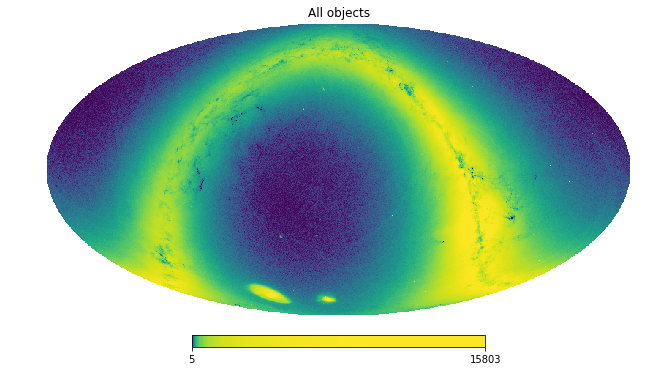

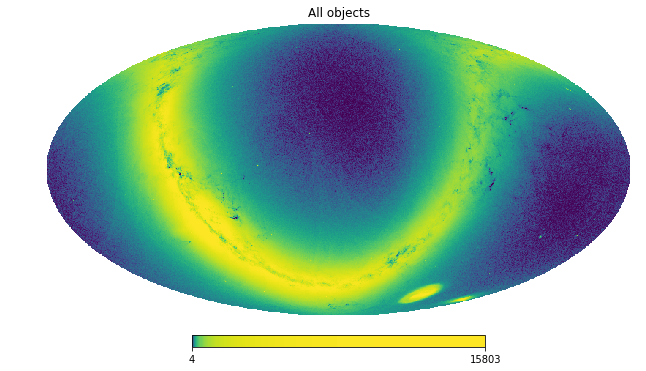

In [11]:
hp.mollview(map_, title="All objects", rot=(0, 0, 0), nest=True, norm='hist')
plt.show()
hp.mollview(map_, title="All objects", rot=(180, 0, 0), nest=True, norm='hist')

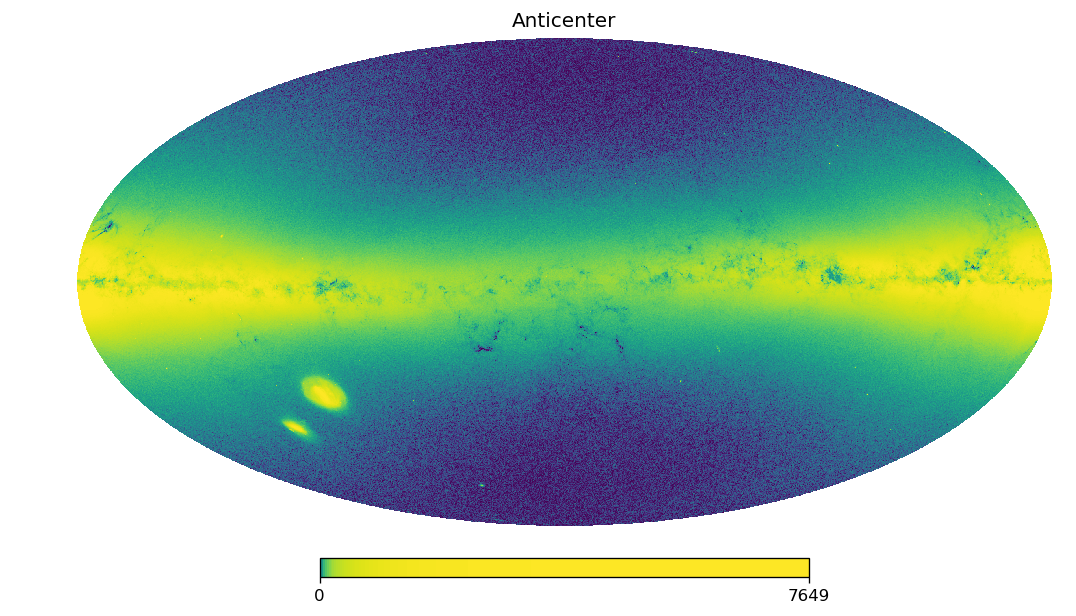

In [68]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(mag_sliced_maps.iloc[18], title="Anticenter",
            #rot=(266.4, -28.94, 180 - 123), # 17h 45.6m	−28.94° Center
            rot=(266.4 - 180, 28.94, -57), # 17h 45.6m	−28.94° Anticenter (?) 
            xsize=2400,
            nest=True, norm='hist')

In [7]:
%%time


gaia_with_bins = gaia.withColumn("magbin", bin_column(14, 22, 16, gaia['phot_g_mean_mag']))
mag_sliced_maps = healpix_hist(gaia_with_bins. \
                               where((gaia_with_bins['dup'] == 0) &
                                     (gaia_with_bins['bp_rp'] > 0.3) & (gaia_with_bins['bp_rp'] < 0.8) &
                                     (gaia_with_bins['magbin'] > 0) & (gaia_with_bins['magbin'] < 17)),
                    groupby=["magbin"], NSIDE=512)

CPU times: user 1.32 s, sys: 308 ms, total: 1.62 s
Wall time: 2min 39s


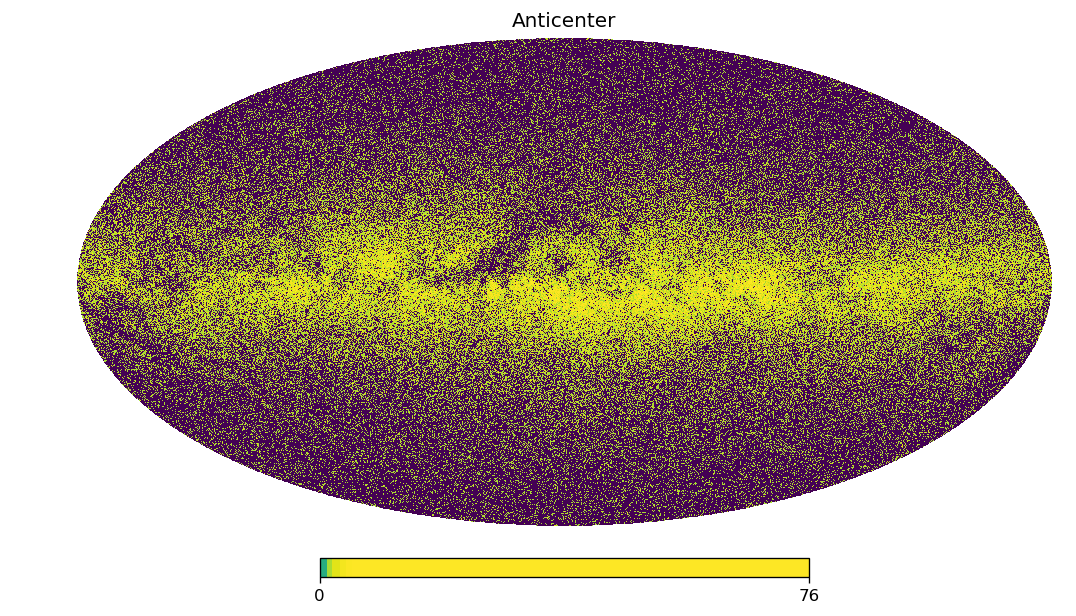

In [10]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(mag_sliced_maps.iloc[10], title="Anticenter",
            rot=(266.4, -28.94, 180 - 123), # 17h 45.6m	−28.94°
                
            xsize=2400,
            nest=True, norm='hist')

In [ ]:
projected_maps = []
for slice in mag_sliced_maps:
    proj_slice = hp.mollview(slice, rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist', return_projected_map=True)
    #proj_slice.fill_value = -1
    projected_maps.append(np.array(proj_slice))
    
compress_output = True
    
if compress_output:
    hdu = astropy.io.fits.CompImageHDU(np.stack(projected_maps), tile_size=(1, 1, 1000))
    hdu.writeto("map_compressed.fits", overwrite=True)
else:
    primaryHdu = astropy.io.fits.PrimaryHDU(np.stack(projected_maps))
    primaryHdu.writeto("proj_map.fits", overwrite=True)


plt.clf()

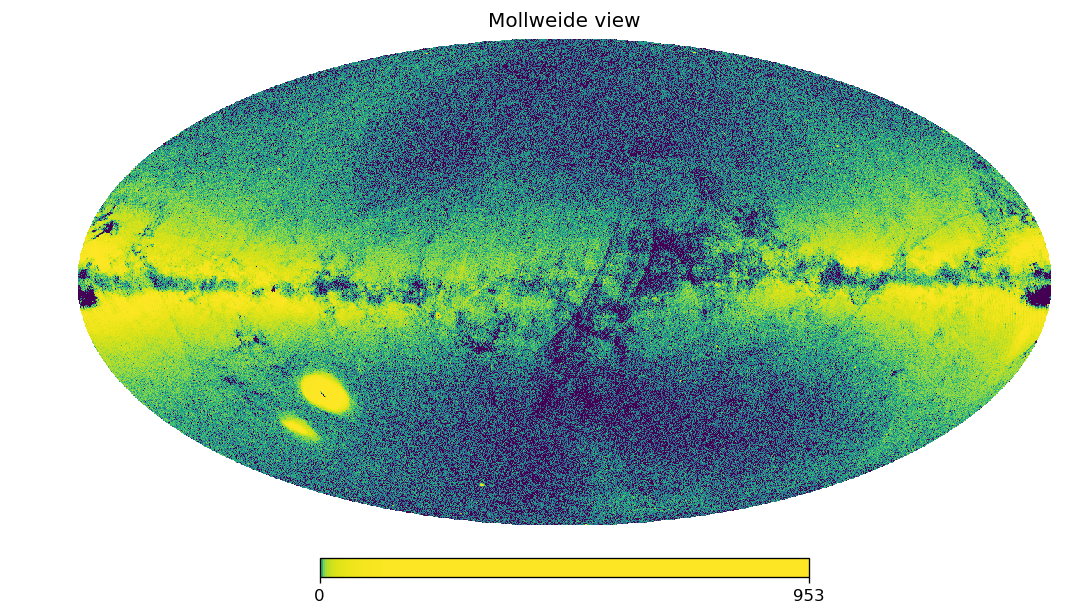

In [10]:
hp.mollview(mag_sliced_maps.iloc[12], rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')

In [117]:
%%time

mean_pm_radec = healpix_hist(gaia_with_bins. \
                               where((gaia_with_bins['dup'] == 0) &
                                     (gaia_with_bins['bp_rp'] > 0.3) & (gaia_with_bins['bp_rp'] < 0.8) &
                                     (gaia_with_bins['magbin'] > 0) & (gaia_with_bins['magbin'] < 17)),
                    groupby=["magbin"], NSIDE=512,  agg={"pmra": "avg", "pmdec": "avg"}, # mean gets rewritten as "avg"
                         )

CPU times: user 2.16 s, sys: 1.85 s, total: 4.01 s
Wall time: 1min 37s


In [121]:
def write_fits_projections(maps, output_filename, overwrite=False, compress_output=True):
    projected_maps = []
    for slice in maps:
        proj_slice = hp.mollview(slice, rot=(266.4 - 180, 28.94, -57),
                xsize=1400,
                nest=True, norm='hist', return_projected_map=True)
        projected_maps.append(np.array(proj_slice))


    if compress_output:
        hdu = astropy.io.fits.CompImageHDU(np.stack(projected_maps), tile_size=(1, 1, 1000))
        hdu.writeto(output_filename, overwrite=overwrite)
    else:
        primaryHdu = astropy.io.fits.PrimaryHDU(np.stack(projected_maps))
        primaryHdu.writeto(output_filename, overwrite=overwrite)
        

In [ ]:
write_fits_projections(mean_pm_radec['avg(pmra)'], "mean_pm_ra.fits", overwrite=True)
write_fits_projections(mean_pm_radec['avg(pmdec)'], "mean_pm_dec.fits", overwrite=True)

In [ ]:
mean_pm_dec = healpix_hist(gaia_with_bins. \
                               where((gaia_with_bins['dup'] == 0) &
                                     (gaia_with_bins['bp_rp'] > 0.3) & (gaia_with_bins['bp_rp'] < 0.8) &
                                     (gaia_with_bins['magbin'] > 0) & (gaia_with_bins['magbin'] < 17)),
                    groupby=["magbin"], NSIDE=512,  agg={"pmra": "avg"}, # mean gets rewritten as "avg"
                         )

/epyc/opt/anaconda/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


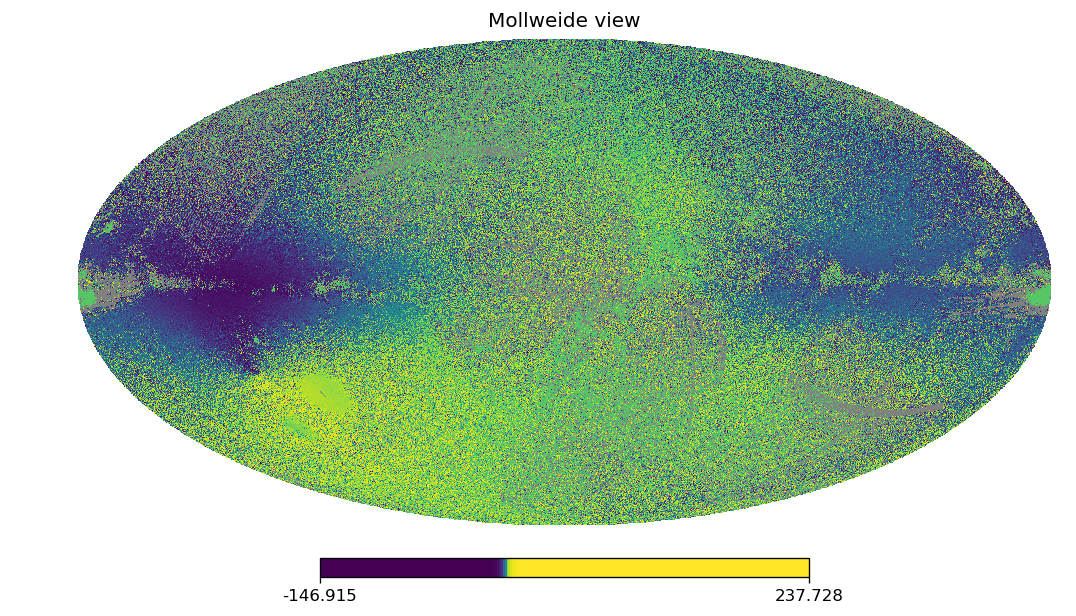

In [115]:
hp.mollview(mean_pm_ra.iloc[12], rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')

Reddening map
---------

In [12]:
a_g_val = gaia.select(gaia['a_g_val']).sample(0.00001).collect()

In [15]:
a_g_val[:10]

[Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=None),
 Row(a_g_val=0.4523000121116638),
 Row(a_g_val=None)]

In [17]:
%%time

a_g_map = healpix_hist(gaia.where((gaia['dup'] == 0)),
                       NSIDE=512,  agg={"a_g_val": "avg"}, # mean gets rewritten as "avg"
                      )

CPU times: user 114 ms, sys: 66 ms, total: 180 ms
Wall time: 1min 3s


/epyc/opt/anaconda/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


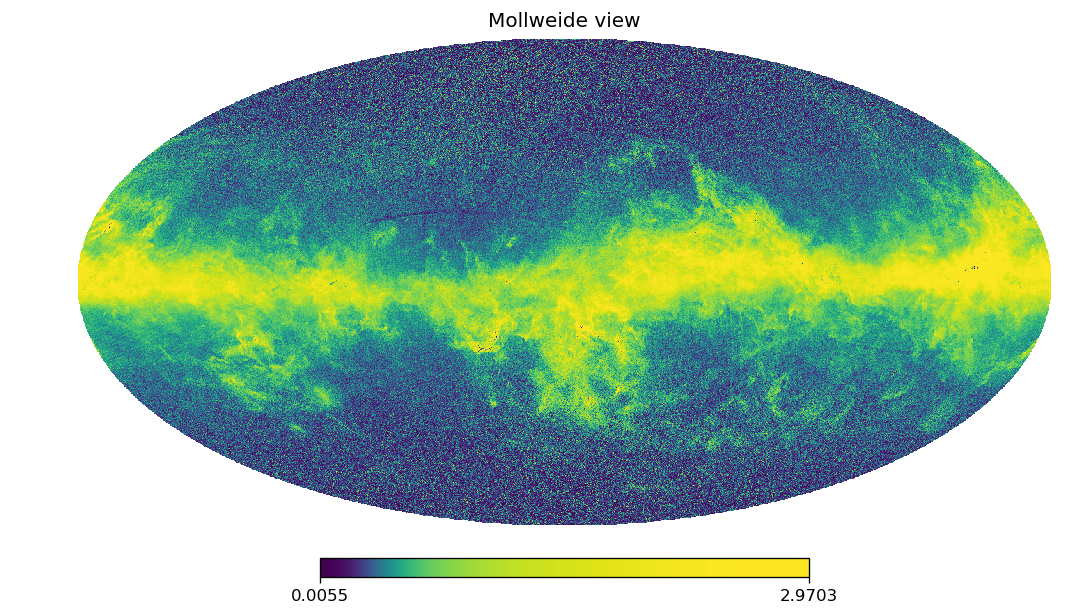

In [29]:
hp.mollview(a_g_map, rot=(266.4 - 180, 28.94, -57),
            xsize=1400, nest=True, norm='hist')

In [131]:
a_g_map_hpix12 = hp.ud_grade(a_g_map, hp.order2nside(12), order_in='NEST')

a_g_df = spark.createDataFrame(pd.DataFrame({"hpix12": np.arange(len(a_g_map_hpix12)),
                                             "a_g_mean": a_g_map_hpix12}))

In [132]:
%%time

gaia_ag = gaia.join(a_g_df, on="hpix12")
gaia_ag_bins = gaia_ag.withColumn("magbin", bin_column(14, 22, 16, gaia_ag['phot_g_mean_mag'] - gaia_ag['a_g_mean']))

dereddened_density = healpix_hist(gaia_ag_bins. \
                                  where((gaia_ag_bins['dup'] == 0) &
                                     (gaia_ag_bins['bp_rp'] > 0.3) & (gaia_ag_bins['bp_rp'] < 0.8) &
                                     (gaia_ag_bins['magbin'] > 0) & (gaia_ag_bins['magbin'] <= 17)),
                                  groupby=["magbin"], NSIDE=512)

CPU times: user 1.57 s, sys: 558 ms, total: 2.13 s
Wall time: 2min 15s


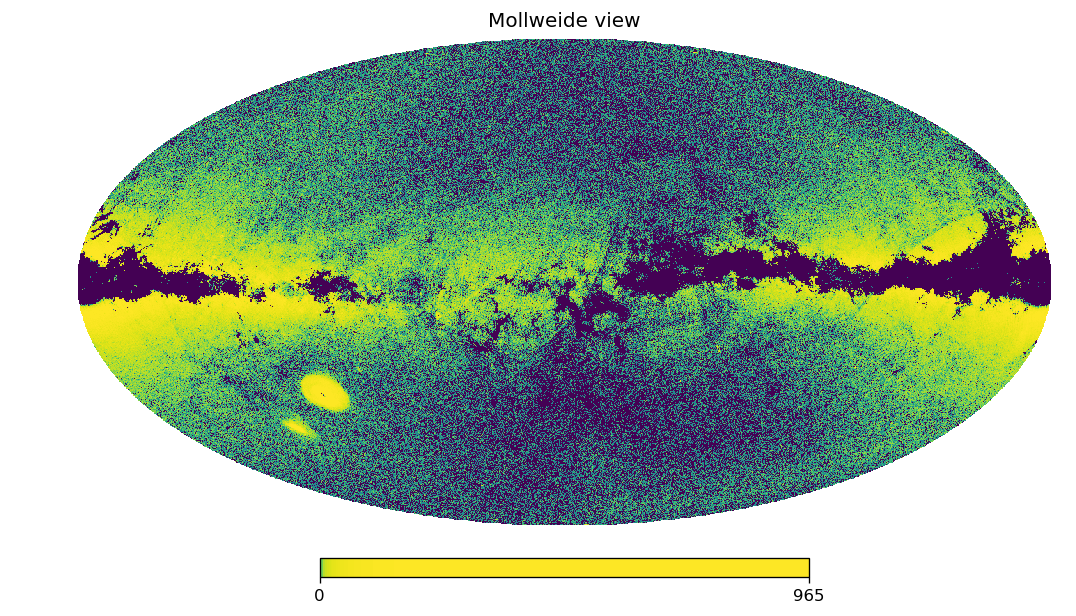

In [133]:
hp.mollview(dereddened_density.iloc[10], rot=(266.4 - 180, 28.94, -57),
            xsize=1400, nest=True, norm='hist')

In [54]:
gaia_ag = gaia.drop("hpix12").withColumn("hpix12",
                        sparkfunc.floor(gaia['source_id']/34359738368)).join(a_g_df, on="hpix12")
gaia_dered = gaia_ag.withColumn("g_dered",  gaia_ag['phot_g_mean_mag'] - gaia_ag['a_g_mean'])

dered_hist = gaia_dered.withColumn("dered_bin", sparkfunc.floor(gaia_dered['g_dered']/.2)).groupBy("dered_bin").count()

In [34]:
%%time
H = dered_hist.collect()

CPU times: user 39.6 ms, sys: 7.18 ms, total: 46.8 ms
Wall time: 3min 14s


In [56]:
%%time

d = dered_hist.toPandas()

CPU times: user 42.7 ms, sys: 8.68 ms, total: 51.4 ms
Wall time: 3min 31s


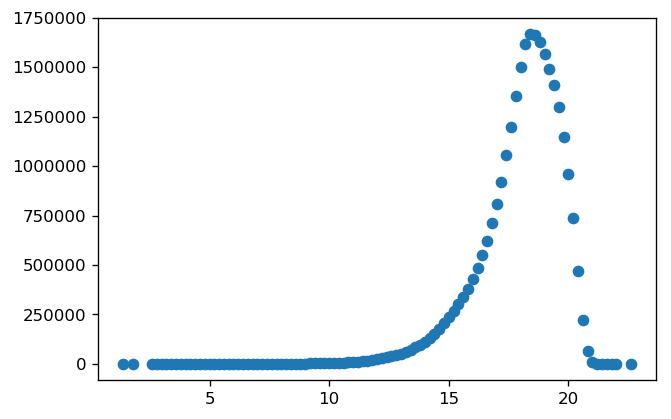

In [57]:
plt.plot(d['dered_bin']*0.2, d['count'], 'o')

Object Hunting
----

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


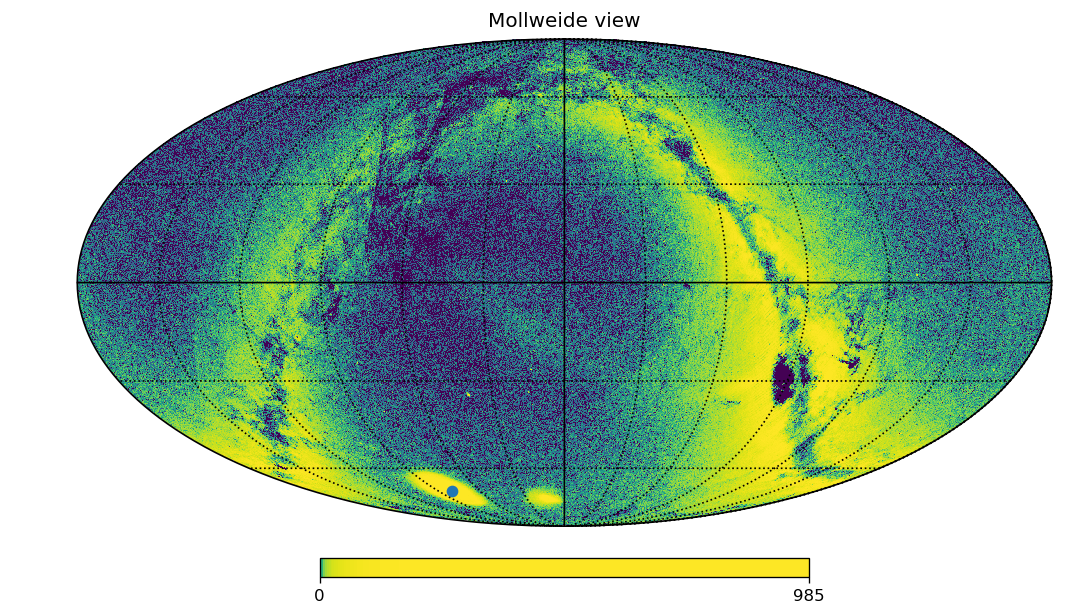

In [138]:
hp.mollview(mag_sliced_maps.iloc[12],
            xsize=1400,
            nest=True, norm='hist', )

hp.projscatter(80.87, -69.5, lonlat=True,) #80.75, -69.5
#hp.projscatter(40, -34., lonlat=True)
hp.graticule()

95.78791147886726 152.21208852113278 5.970072461028655 74.02992753897134
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


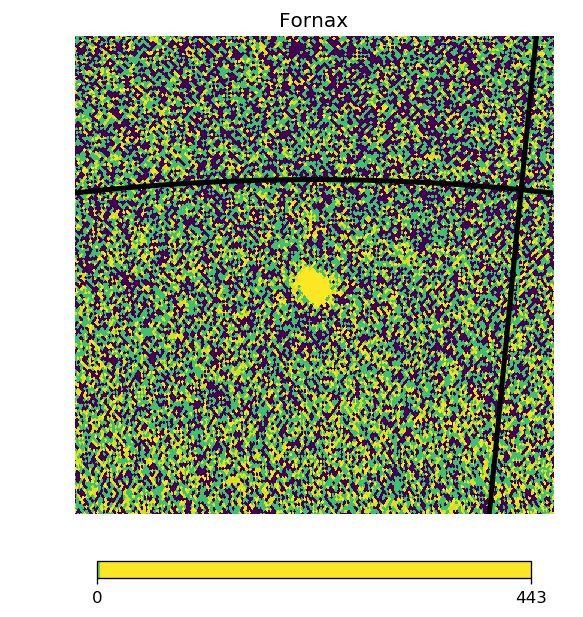

In [137]:
hp.cartview(mag_sliced_maps.iloc[12], title="Fornax",
            rot=(40, -34, 0),
            lonra=(-10, 10), latra=(-10, 10),
            nest=True, norm='hist')
hp.graticule(lw=3, ls='-')